# Results Analysis

In [1]:
import msprime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random
import math
from tqdm import tqdm
from matplotlib.cm import ScalarMappable
import multiprocessing
import istarmap
import itertools
from scipy.stats import gaussian_kde
import torch
from priors import *
from SMC_DRF import DataSimulator
from MSPIDNA_SMC_ABC_RF import Experiment
from priors import generate_prior
import SMC_DRF
from SMC_DRF import *
import rpy2.robjects as robjects

In [13]:
nb_iter = 1
idx_start=0
idx_end=19
real = False
full_sequence = True
path_full_seq = 'full_seq_' if full_sequence else ""
path_real = 'real_' if real else ""
DRF_folder = path_full_seq + path_real + 'DRF_exploitation_of_SPIDNA_results/'
data_folder = path_full_seq + path_real + "data/"
results_folder = path_full_seq + path_real + "results/"
subfolder = f'prior_{nb_iter}/'
perturbation = "adaptative"
custom_exp_name=""
model_custom_exp_name = "_high_mr"
points_to_infere_path= path_full_seq + path_real + f'results/parameters_and_SS_0_prior_1_goals{custom_exp_name}{model_custom_exp_name}.pt'

# Ideas to verify results from MSPIDNA-SMC-ABC-RF (draw new points with posterior & use Markov Chain assumptions)

In [23]:
#Markov Chain method 
N=4000 # number of nucleotides
k=1000 # number of generations
M=100 # number of descendants
ancestor = torch.load("real_ancestor.pt")  # Ancestor sequence
descendants= torch.load("real_descendants.pt") # Descendants
def transition_matrix(ancestor, descendants):
  def q(i,j):
    return sum(sum(ancestor[m]==i and descendants[l][m]==j for m in range(N)) for l in range(M))/(M*(sum(ancestor[m]==i for m in range(N))))
  def matrix_Q():
    Q=np.zeros((4,4))
    for i in range(4):
      for j in range(4):
        Q[i][j]=q(i,j)
    return Q
  Q=np.array(matrix_Q())
  # solve Q=Id+k(P-Id)+k^2 (P-Id)^2
  # Q-Id=k(P-Id)+k^2 (P-Id)^2
  # R=Q-Id, A=k(P-Id), we want R=A+A^2, at first order A=R, A=R+H, R=(R+H)+(R+H)^2, H+R^2=0 approx, H=-R^2, A=R-R^2
  # P=A/k+Id, P=((Q-Id)-(Q-Id)^2)/k +Id
  P=np.zeros((N,N))
  # return P defined by ((Q-Id)-(Q-Id)^2)/k +Id
  P=((Q-np.eye(4))-np.dot(Q-np.eye(4), Q-np.eye(4))/2)/k + np.eye(4)
  #print(Q)
  for i in range(4):
    P = np.maximum(P, 0)
    P[i][i]=0
    P[i]=P[i]/sum(P[i])
  return P

P=transition_matrix(ancestor, descendants)

print(P)

[[0.         0.00652157 0.         0.99347843]
 [0.03166743 0.         0.96833257 0.        ]
 [0.         1.         0.         0.        ]
 [0.97609275 0.         0.02390725 0.        ]]


In [51]:
# Test markov chain method
simulator = DataSimulator(nb_samples=20,root_distribution=[0.32,0.25,0.12,0.31], full_seq=True, real=False)
mutation_rates = generate_prior(type="uniform", a=[1e-5], b=[1e-3], nb_points=20)[0]
transition_matrices = generate_prior(type="dirichlet_transition_matrix", n=4, nb_points=20, null_diag=True)
rmsd = 0
count = 0
for i in range(20):
    args = (mutation_rates[i].numpy(), transition_matrices[i].numpy(), [0.32,0.25,0.12,0.31])
    ancestor, descendants = simulator.simulate2(args)
    
    P=transition_matrix(ancestor, descendants)
    rmsd += ((P - transition_matrices[i].numpy())**2).sum()
    count += 1
rmsd /= count
rmsd = np.sqrt(rmsd)
print(rmsd)

0.37076097974426125


In [29]:
#Generate new dataset with parameters
Y = pd.read_csv(DRF_folder+subfolder+f"Ydrf_0_prior_{nb_iter}_{perturbation}{custom_exp_name}{model_custom_exp_name}.csv")
W = pd.read_csv(DRF_folder+subfolder+f"DRF_weights_0_prior_{nb_iter}_{perturbation}{custom_exp_name}{model_custom_exp_name}.csv").values[:, 0]
W = W[:, np.newaxis]
cond_exp_est = np.sum(Y.to_numpy() * W, axis=0)
l1, l2, l3, l4 = cond_exp_est[1:4], cond_exp_est[4:7], cond_exp_est[7:10], cond_exp_est[10:13]
#insert a 0 for the diagonal
l1 = np.insert(l1, 0, 0)
l2 = np.insert(l2, 1, 0)
l3 = np.insert(l3, 2, 0)
l4 = np.insert(l4, 3, 0)
root_distribution = [0.32,0.23,0.29,0.16]

#ts.draw_svg()
alleles = ["A", "T", "C", "G"]
vects = np.eye(16)
keys = ["AA", "AT", "AC", "AG", "TA", "TT", "TC", "TG", "CA", "CT", "CC", "CG", "GA", "GT", "GC", "GG"]
vects = {key: vects[i] for i, key in enumerate(keys)}
model = msprime.MatrixMutationModel(
    alleles,
    root_distribution = root_distribution,
    #transition_matrix = [l1, l2, l3, l4]
    transition_matrix = P
)
ts = msprime.sim_ancestry(
        50, ploidy=2, sequence_length=4_000, population_size=1000, discrete_genome=True)
mts = msprime.sim_mutations(ts, rate=cond_exp_est[0], 
    discrete_genome=True, model=model)
alleles = ["A", "T", "C", "G"]
count = {ancestral_allele: {derived_allele: 0 for derived_allele in alleles} for ancestral_allele in alleles}
for variant in mts.variants():
    for i in variant.genotypes:
        count[variant.alleles[0]][variant.alleles[i]] += 1
print(count)
print(mts.num_mutations)

{'A': {'A': 8459, 'T': 0, 'C': 0, 'G': 1341}, 'T': {'A': 107, 'T': 6302, 'C': 991, 'G': 0}, 'C': {'A': 0, 'T': 1616, 'C': 8184, 'G': 0}, 'G': {'A': 575, 'T': 0, 'C': 0, 'G': 5225}}
347


In [76]:
#Calculate proportion in descendents : 4000x100 nucleotides
p_A = []
p_T = []
p_C = []
p_G = []

for i in range(100):
    ts = msprime.sim_ancestry(
            50, ploidy=2, sequence_length=4_000, population_size=1000, discrete_genome=True)
    mts = msprime.sim_mutations(ts, rate=cond_exp_est[0], 
        discrete_genome=True, model=model)
    alleles = ["A", "T", "C", "G"]
    count = {ancestral_allele: {derived_allele: 0 for derived_allele in alleles} for ancestral_allele in alleles}
    for variant in mts.variants():
        for i in variant.genotypes:
            count[variant.alleles[0]][variant.alleles[i]] += 1
            total_count = sum(count["A"].values())+sum(count["T"].values())+sum(count["C"].values())+sum(count["G"].values())
    num_sites = total_count//100
    root_distribution = [0.32,0.23,0.29,0.16]
    p_a = (root_distribution[0]*(4000*100 - total_count)+(count["A"]["A"] + count["T"]["A"] + count["C"]["A"] + count["G"]["A"]))/(4000*100)
    p_t = (root_distribution[1]*(4000*100 - total_count)+(count["A"]["T"] + count["T"]["T"] + count["C"]["T"] + count["G"]["T"]))/(4000*100)
    p_c = (root_distribution[2]*(4000*100 - total_count)+(count["A"]["C"] + count["T"]["C"] + count["C"]["C"] + count["G"]["C"]))/(4000*100)
    p_g = (root_distribution[3]*(4000*100 - total_count)+(count["A"]["G"] + count["T"]["G"] + count["C"]["G"] + count["G"]["G"]))/(4000*100)
    p_A.append(p_a)
    p_T.append(p_t)
    p_C.append(p_c)
    p_G.append(p_g)
print(f"p_A : {np.mean(p_A).__round__(3)}")
print(f"p_T : {np.mean(p_T).__round__(3)}")
print(f"p_C : {np.mean(p_C).__round__(3)}")
print(f"p_G : {np.mean(p_G).__round__(3)}")

p_A : 0.285
p_T : 0.245
p_C : 0.276
p_G : 0.194


# Individual DRF Plotting functions

In [46]:
#Plot transitions-matrix posteriors for different priors 
def compare_1D_posteriors(nb_iter, idx, perturbation, DRF_folder, custom_exp_name=None, model_custom_exp_names=None):
    sns.set_style("darkgrid")
    params_target= pd.read_csv(DRF_folder+f'params_targets_{idx}{custom_exp_name}{model_custom_exp_names[0]}.csv')
    # Create a figure with 4 rows and 3 columns of subplots
    nb_col = params_target.shape[1]//4
    nb_row = 4
    fig, axes = plt.subplots(nb_row, nb_col, figsize=(25, 20))
    axes = axes.flatten()  # Flatten the 2D array of axes to a 1D array for easier indexing
    num_curves = len(model_custom_exp_names)
    #cmap from green to red
    colors = [(0, "green"), (0.5, "orange"), (1, "red")]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    for i, ax in enumerate(axes):
        for j, model_custom_exp_name in enumerate(model_custom_exp_names):
            params_target= pd.read_csv(DRF_folder+f'params_targets_{idx}{custom_exp_name}{model_custom_exp_name}.csv')
            custom_exp_name = custom_exp_name if custom_exp_name is not None else ''
            model_custom_exp_name = model_custom_exp_name if model_custom_exp_name is not None else ''
            Ydrf = pd.read_csv(DRF_folder + f'prior_{nb_iter}/Ydrf_{idx}_prior_{nb_iter}_{perturbation}{custom_exp_name}{model_custom_exp_name}.csv')
            W = pd.read_csv(DRF_folder + f'prior_{nb_iter}/DRF_weights_{idx}_prior_{nb_iter}_{perturbation}{custom_exp_name}{model_custom_exp_name}.csv').values[:, 0]
            if i+1 < params_target.shape[1]:
                col_to_plot = Ydrf.columns[i+1]
                Y = Ydrf[col_to_plot]
                Y_values = np.linspace(min(Y), max(Y), 1000)
                posterior_kde = gaussian_kde(Y, weights=W)
                posterior_density = posterior_kde(Y_values)
                #PLOT POSTERIOR
                limit_left = int(-7 + j)
                limit_right = int(-5 + j)
                ax.plot(Y_values, posterior_density, label=fr'$\pi^T\left(\theta_{{i}}|\mathbf{{X}}^{{obs}}_{{mtDNA}}, \theta_1 \in [10^{{{limit_left}}},10^{{{limit_right}}}]\right)_{{2\leq i \leq 13}}$', color=cmap(j / (num_curves-1)))
                ax.fill_between(Y_values, posterior_density, color=cmap(j / (num_curves-1)), alpha=0.05)
                cond_exp_est = np.sum(Y.to_numpy() * W)
                # PLOT COND EXP
                ax.axvline(cond_exp_est, color=cmap(j / (num_curves-1)), linestyle='--', 
                           label=fr'$\mathbb{{E}}_{{\pi^T}}[\theta_{{i}}|\mathbf{{X}}^{{obs}}_{{mtDNA}},\theta_1\in [10^{{{limit_left}}},10^{{{limit_right}}}]]_{{2\leq i \leq 13}}$')
                ax.set_title(fr'$\pi_{{\mathrm{{index}}}}$'.replace('index', str(col_to_plot[-2:])), fontsize = 25)
                ax.set_xlabel('Values', fontsize = 20)
                ax.set_ylabel('Density', fontsize = 20)
    
    # Add a global legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=25, bbox_to_anchor=(0.5, 0), ncol=3)
    os.makedirs(os.path.dirname(DRF_folder + f'figures/prior_{nb_iter}/1D_posteriors/'), exist_ok=True)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.savefig(DRF_folder + f'figures/prior_{nb_iter}/1D_posteriors/ABC_DRF_{idx}_comparison.png')
    print(f'{nb_iter} : 1D_posteriors for {idx} saved in {DRF_folder}figures/prior_{nb_iter}/1D_posteriors/ABC_DRF_{idx}_comparison.png')
    plt.close()

compare_1D_posteriors(nb_iter, 0, perturbation, DRF_folder, custom_exp_name, model_custom_exp_names=["", "_high_mr", "_ery_high_mr"])

# RMSD / AED

In [9]:
#calculate RMSD, AED and RRMSE
rmsds = []
aeds = []
rrmses = []
for iter in range (1,6):
    subfolder = f'prior_{iter}/'
    test_mr = pd.DataFrame(pd.read_csv(DRF_folder + f"mse_{iter}_adaptative{custom_exp_name}{model_custom_exp_name}.csv")).iloc[:,0]
    p = test_mr.shape[0]
    mr_norm2_mean = test_mr.mean()
    normalisation = 0
    for idx in range(idx_start,idx_end+1):
        if iter!=1:
            Y_posterior = pd.read_csv(DRF_folder+subfolder+f'Ydrf_{idx}_prior_{iter}_{perturbation}{custom_exp_name}{model_custom_exp_name}.csv')
        else:
            Y_posterior = pd.read_csv(DRF_folder+subfolder+f'Ydrf_{idx}_prior_{iter}{custom_exp_name}{model_custom_exp_name}.csv')
        mse =  (Y_posterior.mean(axis=0).iloc[0])**2
        normalisation += mse
    normalisation = np.sqrt(normalisation/15)
    #transition parameters
    test = pd.DataFrame(pd.read_csv(DRF_folder + f"mse_{iter}_adaptative{custom_exp_name}{model_custom_exp_name}.csv")).iloc[:,1:]
    #L2 Norm of the parameters
    test["norm2"] = np.linalg.norm(test.values, ord=1, axis=1)
    test["norm"] = np.sqrt(test["norm2"])
    norm2_mean = test["norm2"].mean()
    norm_mean = test["norm"].mean()
    norm2_std = test["norm2"].std()
    norm_std = test["norm"].std()
    #print(f"MR RMSD: {np.sqrt(mr_norm2_mean)}")
    #print(f"MR RRMSE: {(np.sqrt(mr_norm2_mean)/normalisation):.3f}")
    #print(f"RMSD: {np.sqrt(norm2_mean):.3f} +/- {norm2_std/(4*norm2_mean):.3f}")
    #print(f"AED norm mean : {norm_mean:.3f} +/- {norm_std:.3f}")
    rmsds.append(np.sqrt(norm2_mean))
    rrmses.append(np.sqrt(mr_norm2_mean)/normalisation)
    aeds.append(norm_mean)

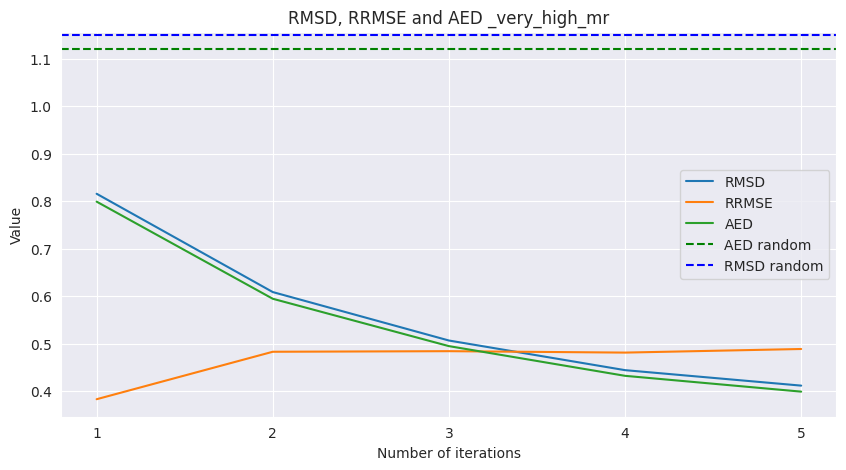

In [10]:
#plot rmsd, rrmse, aed, mrrmsd in function of iter
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.plot(range(1,6), rmsds, label="RMSD")
plt.plot(range(1,6), rrmses, label="RRMSE")
plt.plot(range(1,6), aeds, label="AED")
#horizontal line AED_random : y = 1.12
plt.axhline(y=1.12, color='g', linestyle='--', label="AED random")
#horizontal line RMSD_random : y = 1.15
plt.axhline(y=1.15, color='b', linestyle='--', label="RMSD random")
plt.xlabel("Number of iterations")
plt.xticks(np.arange(1, 6, 1))
plt.ylabel("Value")
plt.legend(loc="best")
plt.title(f"RMSD, RRMSE and AED {model_custom_exp_name}")
plt.show()

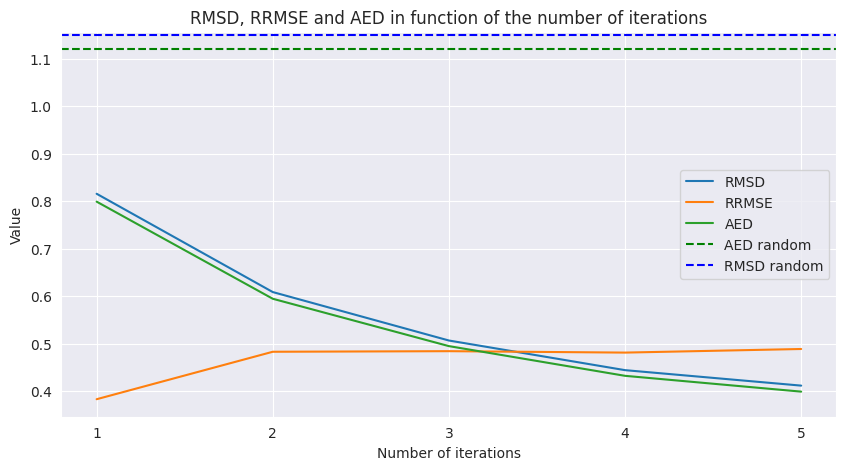

In [14]:
#plot rmsd, rrmse, aed, mrrmsd in function of iter
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.plot(range(1,6), rmsds, label="RMSD")
plt.plot(range(1,6), rrmses, label="RRMSE")
plt.plot(range(1,6), aeds, label="AED")
#horizontal line AED_random : y = 1.12
plt.axhline(y=1.12, color='g', linestyle='--', label="AED random")
#horizontal line RMSD_random : y = 1.15
plt.axhline(y=1.15, color='b', linestyle='--', label="RMSD random")
plt.xlabel("Number of iterations")
plt.xticks(np.arange(1, 6, 1))
plt.ylabel("Value")
plt.legend(loc="best")
plt.title("RMSD, RRMSE and AED in function of the number of iterations")
plt.show()

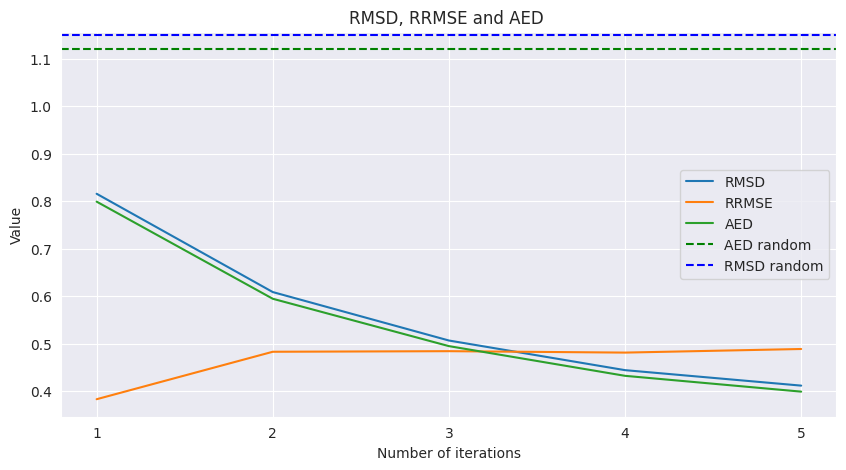

In [12]:
#plot rmsd, rrmse, aed, mrrmsd in function of iter
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
plt.plot(range(1,6), rmsds, label="RMSD")
plt.plot(range(1,6), rrmses, label="RRMSE")
plt.plot(range(1,6), aeds, label="AED")
#horizontal line AED_random : y = 1.12
plt.axhline(y=1.12, color='g', linestyle='--', label="AED random")
#horizontal line RMSD_random : y = 1.15
plt.axhline(y=1.15, color='b', linestyle='--', label="RMSD random")
plt.xlabel("Number of iterations")
plt.xticks(np.arange(1, 6, 1))
plt.ylabel("Value")
plt.legend(loc="best")
plt.title(f"RMSD, RRMSE and AED {model_custom_exp_name}")
plt.show()

# Individual SMC_ABC-RF functions

In [ ]:
#create csv for DRF
params = [(points_to_infere_path, results_folder + f'parameters_and_SS_{idx}_prior_{nb_iter}_{perturbation}.pt', 
           nb_iter, idx, perturbation) for idx in range(idx_start, idx_end+1)]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for _ in tqdm(pool.istarmap(create_csv_for_DRF, params),total=len(params), desc='Generate Ydrf'):
            pass

In [ ]:
#Run DRF script
robjects.r['source']('abc_drf.r')
generate_DRF_weights = robjects.r['generate_DRF_weights']
for idx in range(idx_start, idx_end+1):
    generate_DRF_weights(nb_iter, "adaptative", idx, DRF_folder)

In [ ]:
#plot 1D posteriors for mutation_rate
params = [([0], nb_iter, idx, perturbation, DRF_folder, custom_exp_name, model_custom_exp_name) for idx in range(idx_start, idx_end+1)]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for _ in tqdm(pool.istarmap(plot_1D_posterior_custom, params),total=len(params), desc='Plotting 1D posteriors'):
            pass

In [ ]:
#plot 1D posteriors for transition_matrix
params = [(nb_iter, idx, perturbation, DRF_folder, custom_exp_name, model_custom_exp_name) for idx in range(idx_start, idx_end+1)]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for _ in tqdm(pool.istarmap(plot_1D_posteriors, params),total=len(params), desc='Plotting 1D posteriors'):
            pass

In [3]:
#Plot 2D posteriors
params = [(i,j, nb_iter, idx, perturbation, DRF_folder, subfolder, 
           custom_exp_name, model_custom_exp_name) for idx, i, j in itertools.product(range(idx_start, idx_end+1), range(1,13), range(1,13))]
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    for _ in tqdm(pool.istarmap(plot_2D_posterior, params), total = len(params), desc='Plotting 2D posteriors'):
        pass

Plotting 2D posteriors: 100%|██████████| 720/720 [42:13<00:00,  3.52s/it]  


In [3]:
#Merge the 2D distributions in one figure
params = [(idx, perturbation, DRF_folder, subfolder, custom_exp_name, model_custom_exp_name) for idx in range(idx_start, idx_end+1)]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for _ in tqdm(pool.istarmap(merge_2D_posteriors, params),total=len(params), desc='Merging 2D posteriors'):
            pass

Merging 2D posteriors: 100%|██████████| 5/5 [02:45<00:00, 33.05s/it] 


In [ ]:
#mse
for idx in range(idx_start, idx_end+1):
    mse(nb_iter, idx, perturbation, DRF_folder, subfolder, custom_exp_name, model_custom_exp_name)

In [8]:
#Sample new Prior from weights
mins, maxs = np.zeros(13), np.ones(13)
mins[0], maxs[0] = 1e-7, 1e-5
perturbation = "adaptative"

params = [(mins, maxs, nb_iter, idx, perturbation, DRF_folder, subfolder, data_folder, 
           5000, custom_exp_name, model_custom_exp_name) for idx in range(idx_start, idx_end+1)]

with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for _ in tqdm(pool.istarmap(posterior_sampling, params),total=len(params), desc='Posterior Sampling'):
            pass

Posterior Sampling: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
